<a href="https://colab.research.google.com/github/shengy90/MSc-Project/blob/master/notebook/Exploring_Clustering_5th_July.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### **Authenticate with BigQuery ☁️**

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
%%bigquery --project machine-learning-msc df
SELECT 
  COUNT(*) as total_rows
FROM `machine-learning-msc.low_carbon_london.household_consumption_daily_agg` 

In [3]:
df

,total_rows
0,212832


### **Importing Libraries⏬**

In [4]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import random

from datetime import date

sns.set()
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Exploring Dataset 🔭**

Note - this can take a while to download!

In [173]:
%%bigquery --project machine-learning-msc df
SELECT 
*
FROM `machine-learning-msc.low_carbon_london.household_consumption_daily_agg` 

### **Comparing daily load profiles of 3 random lcl_ids**

In [174]:
df.head()

,lcl_id,acorn_grouped,acorn,hhourly_rank,hh_avg,hh_max,hh_min,hh_stddev,hh_median,hh_quartile_25,hh_quartile_75
0,MAC000606,Affluent,B,35,0.306936,1.629,0.140,0.222118,0.2530,0.19600,0.30900
1,MAC000606,Affluent,B,17,0.286071,1.381,0.051,0.145173,0.2910,0.18900,0.34075
2,MAC000606,Affluent,B,22,0.138650,1.493,0.043,0.160965,0.0980,0.08200,0.12325
3,MAC000606,Affluent,B,41,0.320607,0.998,0.170,0.137166,0.2975,0.25800,0.32850
4,MAC000606,Affluent,B,32,0.163629,1.932,0.041,0.208352,0.1120,0.08575,0.16475


In [199]:
def pick_random_lclids(df, num, cluster_num=None):
    """
    Function to pick random `num` lcl_ids from dataset
    Parameters:
        df : input dataframe 
        num: number of lcl_ids to output
    """
    if cluster_num is None:
        all_lcl_ids = list(set(df['lcl_id']))
    else:
        all_lcl_ids = list(set(df.query(f"cluster=={cluster_num}")['lcl_id']))
    return np.random.choice(all_lcl_ids, num, replace=False) 

def plot_load_profiles(df, num, cluster_num=None):
    """
    Function to plot load profiles of `num` random lcl_ids from dataset
    Parameteres:
        df: input dataframe
        num: number of lcl_ids to plot
    """
    lcl_ids = pick_random_lclids(df, num, cluster_num)
    plot_df = pd.DataFrame(columns=df.columns)
    for lcl_id in lcl_ids:
        lcl_id_df = df.query(f"lcl_id == '{lcl_id}'")
        acorn_group = lcl_id_df.iloc[0]['acorn_grouped']
        acorn = lcl_id_df.iloc[0]['acorn']
        print(f"{lcl_id}: {acorn_group}, {acorn}")
        plot_df = pd.concat([plot_df, lcl_id_df])
    
    if cluster_num is None:
        title = "Load profiles of 3 random lcl_ids"
    else:
        title = f"Load profiles of 3 random lcl_ids from cluster {cluster_num}"
    plt.figure(figsize=(20, 5))
    sns.lineplot(x='hhourly_rank', y="hh_avg", data=plot_df, hue='lcl_id').set_title(title)

MAC005379: Comfortable, F
MAC002979: Adversity, P
MAC001259: Comfortable, I


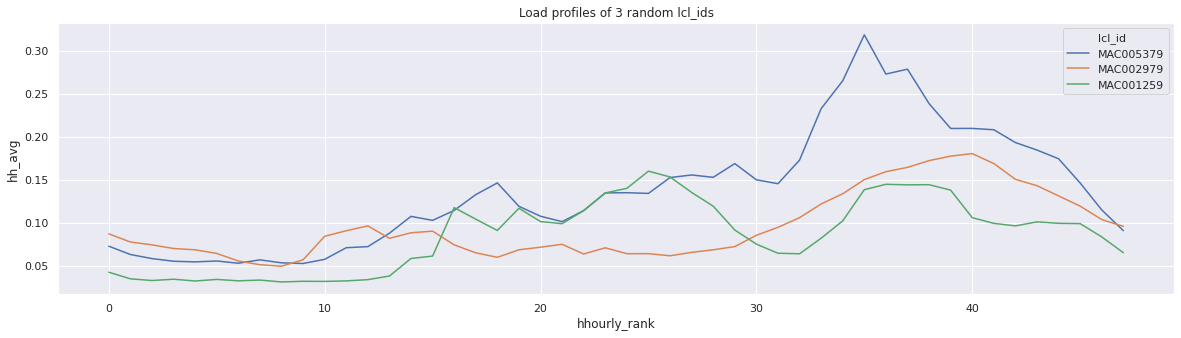

In [100]:
plot_load_profiles(df, 3)

MAC004036: Adversity, L
MAC000861: Affluent, E
MAC003349: Affluent, C


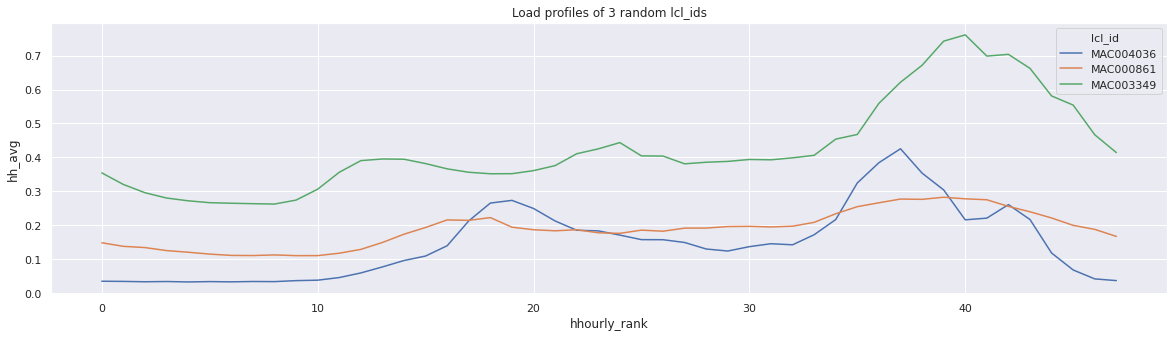

In [101]:
plot_load_profiles(df, 3)

MAC000952: Adversity, Q
MAC000428: Adversity, L
MAC001081: Affluent, E


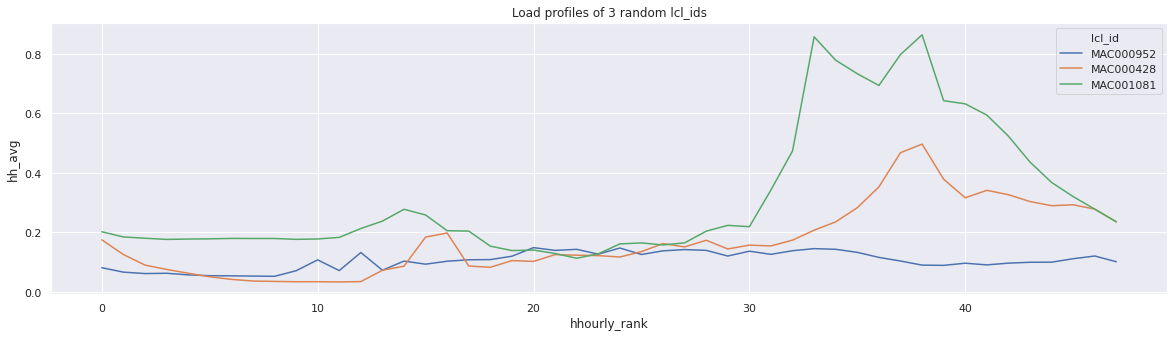

In [102]:
plot_load_profiles(df, 3)

### **Pivot Dataframe**

In [103]:
df_wide = df.pivot(index='lcl_id', 
                    columns='hhourly_rank',
                    values=['hh_avg', 
                            'hh_max', 
                            'hh_min',
                            'hh_stddev'
                    ]
                                    )
df_wide.columns = [''.join(str(col)) for col in df_wide.columns]

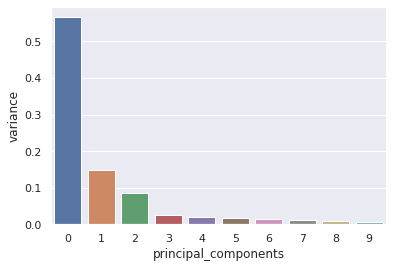

In [104]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

normalised_df = StandardScaler().fit_transform(df_wide)
pca = PCA(n_components=10)
principal_components = pca.fit_transform(normalised_df)
pca_df = pd.DataFrame(
    {'variance' : pca.explained_variance_ratio_,
     'principal_components': range(pca.n_components)}
     )
sns.barplot(x='principal_components', y='variance', data=pca_df)

In [105]:
pca_components = pd.DataFrame(
    index=df_wide.index,
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5','PC6','PC7','PC8','PC9','PC10'],
    data = principal_components
    )

Text(0.5, 0, 'PC3')

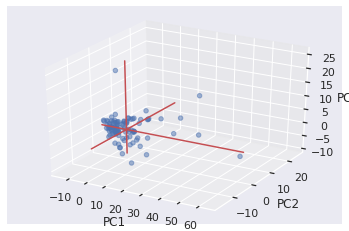

In [106]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sampled_df = pca_components.sample(100)

ax.scatter(sampled_df['PC1'], sampled_df['PC2'], sampled_df['PC3'], cmap="Set2_r", alpha=0.5)

xAxisLine = ((min(sampled_df['PC1']), max(sampled_df['PC1'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(sampled_df['PC2']), max(sampled_df['PC2'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(sampled_df['PC3']), max(sampled_df['PC3'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

### **Try Hierarchical Clustering**

In [108]:
df_pca = pca_components[['PC1', 'PC2', 'PC3']].copy()

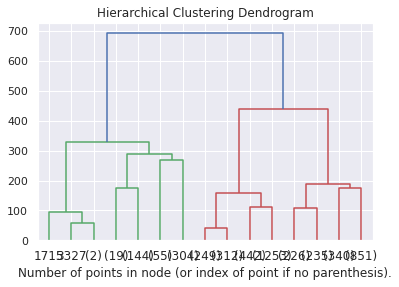

In [163]:

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

tree = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(df_pca)

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(tree, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


In [165]:
cluster = AgglomerativeClustering(n_clusters=8).fit(df_pca)

In [180]:
df_pca_labelled = df_pca.copy()
df_pca_labelled['cluster'] = cluster.labels_
df_pca_labelled['cluster'] = pd.Categorical(df_pca_labelled['cluster'])
df_pca_labelled.reset_index(inplace=True)

Text(0.5, 0, 'PC3')

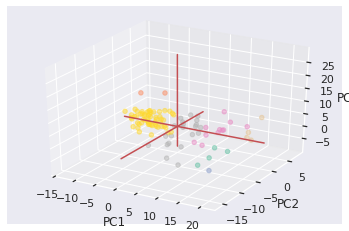

In [181]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sampled_df = df_pca_labelled.sample(100)
cat_colours = sampled_df['cluster'].cat.codes
ax.scatter(sampled_df['PC1'], sampled_df['PC2'], sampled_df['PC3'], c =cat_colours, cmap="Set2_r", alpha=0.5)

xAxisLine = ((min(sampled_df['PC1']), max(sampled_df['PC1'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(sampled_df['PC2']), max(sampled_df['PC2'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(sampled_df['PC3']), max(sampled_df['PC3'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

In [187]:
df_pca_labelled.groupby('cluster').count()

,lcl_id,PC1,PC2,PC3
cluster,,,,
0,1191,1191,1191,1191
1,163,163,163,163
2,2256,2256,2256,2256
3,461,461,461,461
4,59,59,59,59
5,55,55,55,55
6,245,245,245,245
7,4,4,4,4


In [182]:
clustered_df = df.merge(
    df_pca_labelled[['lcl_id','cluster']],
    on='lcl_id'
)

MAC000720: Adversity, K
MAC001578: Adversity, K
MAC004991: Affluent, E
MAC003597: Affluent, A
MAC001734: Affluent, A
MAC003349: Affluent, C
MAC002454: Affluent, E
MAC000648: Comfortable, F
MAC001954: Affluent, E
MAC001099: Affluent, E
MAC001664: Affluent, C
MAC000255: Adversity, K
MAC001705: Affluent, E
MAC004016: Affluent, D
MAC003602: Comfortable, H
MAC005336: Adversity, Q
MAC005327: Affluent, E
MAC000153: Affluent, E
MAC001864: Adversity, L
MAC005348: Adversity, P
MAC003025: Comfortable, J
MAC002155: Affluent, D
MAC000557: Affluent, A
MAC004179: Affluent, A


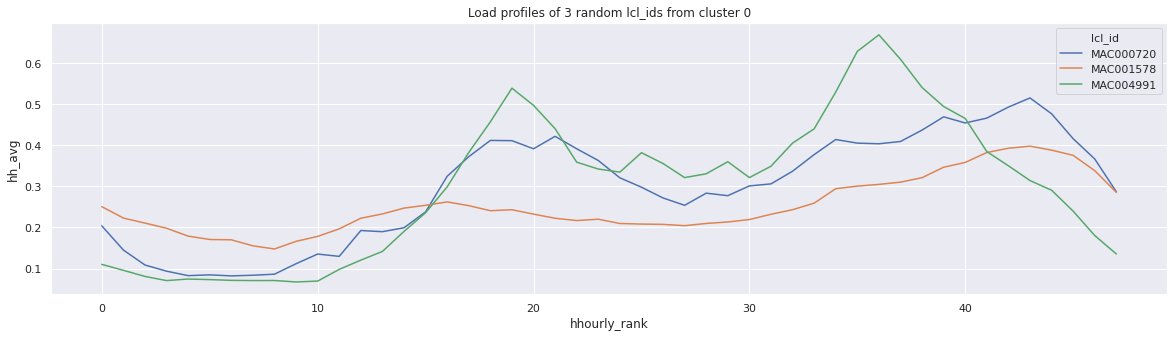

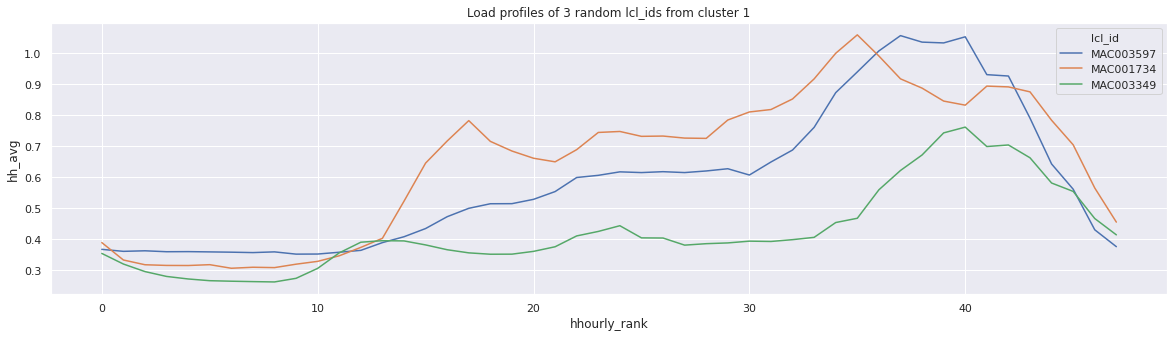

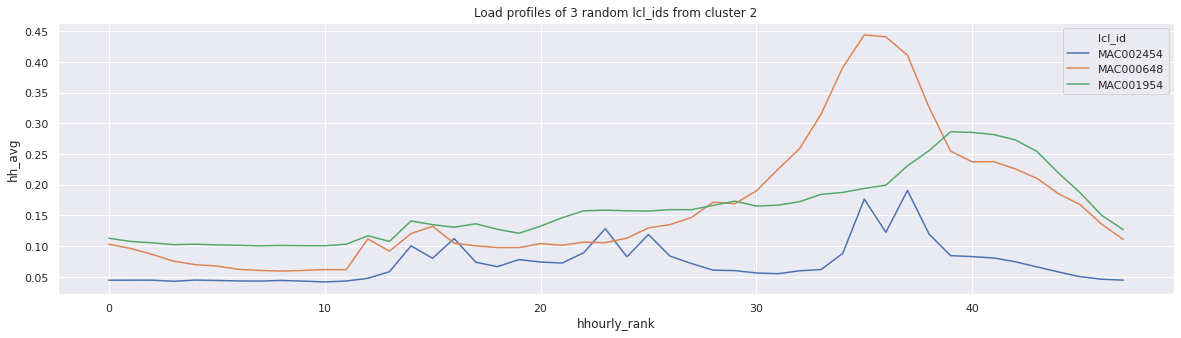

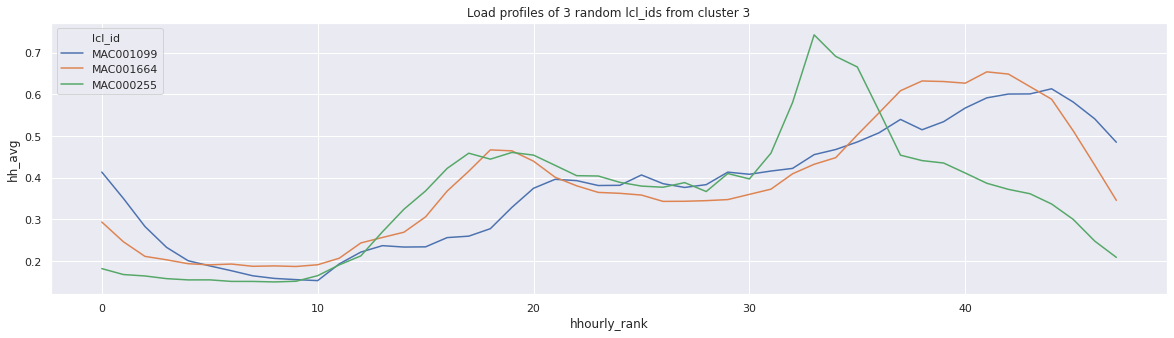

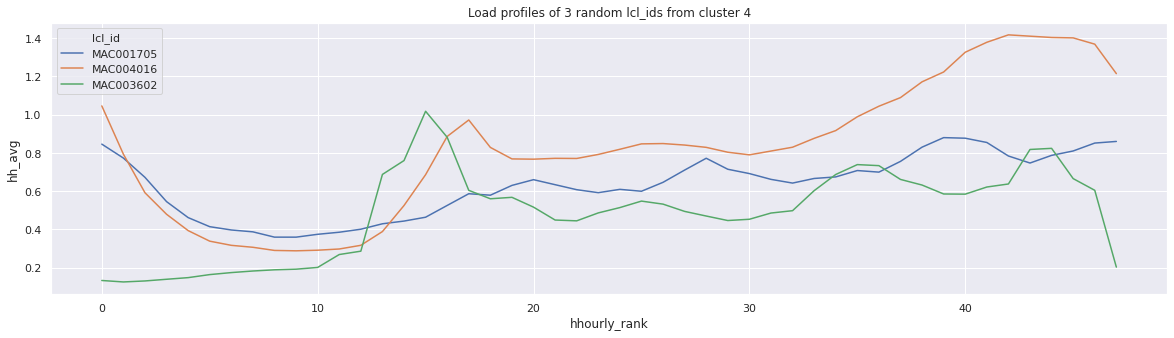

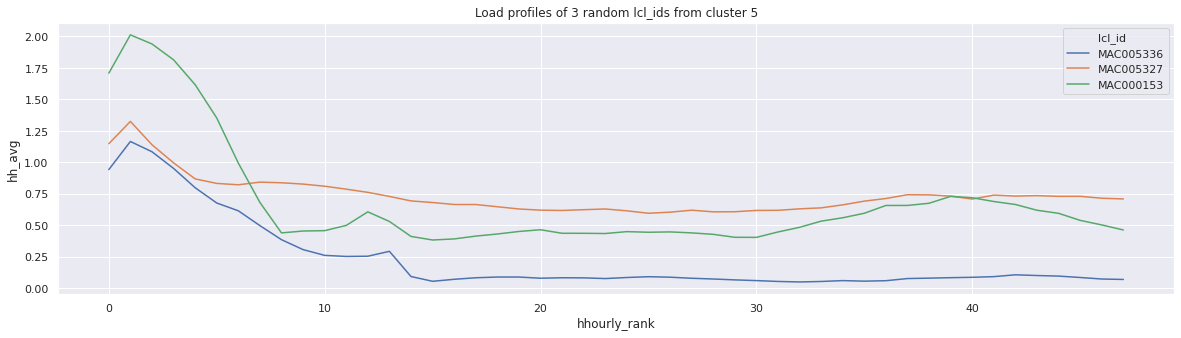

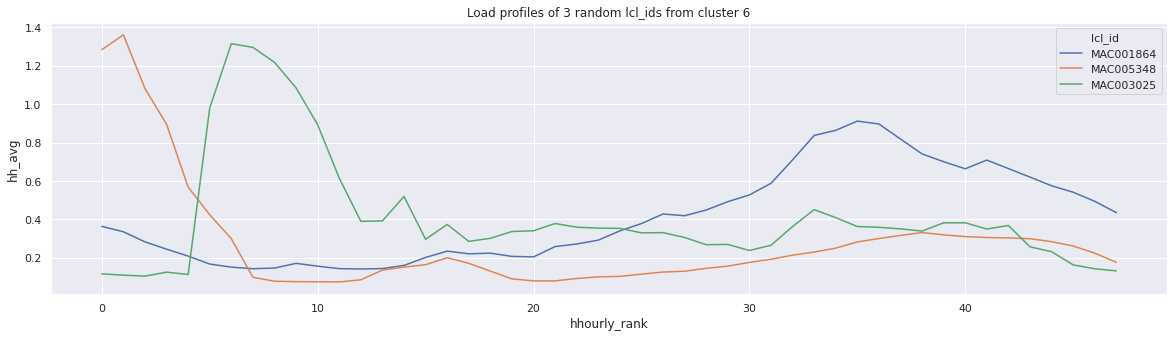

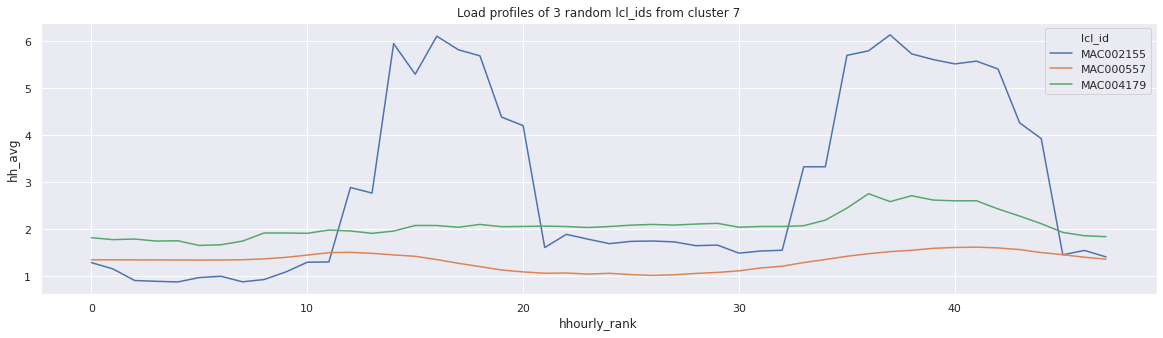

In [200]:
for cluster_num in range(0,8):
    plot_load_profiles(clustered_df, 3, cluster_num)
